Project Introduction: Weighted Aging Curve Analysis of MLB Batters.

Project Goal: To accurately quantify the average rate of performance decline in MLB batters attributable purely to aging. This model provides an essential component for any comprehensive player projection system used in baseball operations.

Methodology: I apply the Delta Method using Weighted Linear Regression on historical data from the Lahman Database (2000–2024). This approach minimizes common statistical biases and prioritizes data from players with stable playing time.

Core Metric: Weighted On-Base Average ($\text{wOBA}$) is used as the performance benchmark due to its superior run-value weighting compared to traditional metrics.

Tools: R (tidyverse, Lahman, tidymodels), Google Colab, and Tableau (for final visualization).

1. Project Setup and Data Strategy

To begin, I set up the R environment by installing and loading the necessary packages. The core of this project relies on the tidyverse for data manipulation and the Lahman package, which provides a highly stable, audited source of historical MLB data. I also loaded tidymodels for advanced statistical modeling. Loading these packages ensures all the specialized functions I need (like filter, mutate, and lm) are available for use.

In [1]:
# Install packages
install.packages(c("tidyverse", "baseballr", "tidymodels"))

# Load packages
library(tidyverse)
library(baseballr)
library(tidymodels)

# Install the Lahman package (only run once)
install.packages("Lahman")

# Load the necessary packages
library(Lahman)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘shape’, ‘future.apply’, ‘numDeriv’, ‘progressr’, ‘SQUAREM’, ‘diagram’, ‘lava’, ‘listenv’, ‘parallelly’, ‘prodlim’, ‘future’, ‘warp’, ‘lhs’, ‘snakecase’, ‘DiceDesign’, ‘sfd’, ‘sparsevctrs’, ‘patchwork’, ‘globals’, ‘clock’, ‘gower’, ‘ipred’, ‘timeDate’, ‘furrr’, ‘slider’, ‘GPfit’, ‘modelenv’, ‘janitor’, ‘RcppParallel’, ‘dials’, ‘hardhat’, ‘infer’, ‘modeldata’, ‘parsnip’, ‘recipes’, ‘rsample’, ‘tailor’, ‘tune’, ‘workflows’, ‘workflowsets’, ‘yardstick’


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use

2. Data Acquisition, Pre-Calculation, and Filtering

This block accesses the Lahman::Batting table, which holds all the raw component statistics. I used the dplyr pipeline (%>%) to sequentially clean the data. Then, I calculated the advanced metric Weighted On-Base Average ($\text{wOBA}$), as this is the standard metric for modern player evaluation. I also calculate the player's true $\text{Age}$ and ensure all data points have sufficient playing time ($\text{PA} \ge 150$) to produce reliable results.

In [2]:
# 1. Access the Batting table
df <- Batting %>%

  # 2. FILTER using At-Bats (AB), as PA does not exist yet!
  filter(yearID >= 2000, AB >= 100) %>% # Using AB >= 100 as a reliable filter for playing time

  # 3. Calculate all necessary variables for wOBA and Age
  mutate(
    X1B = H - X2B - X3B - HR, # Calculate Singles
    PA = AB + BB + HBP + SF,  # <--- PA is now created here!

    # Calculate wOBA (using 2024 standardized weights)
    wOBA_Num =
      0.69 * BB +
      0.72 * HBP +
      0.89 * X1B +
      1.27 * X2B +
      1.62 * X3B +
      2.10 * HR,

    wOBA_Den = AB + BB + HBP + SF - IBB,

    wOBA = wOBA_Num / wOBA_Den
  ) %>%

  # 4. Merge with the People table to get the player's birth year for Age calculation
  left_join(People %>% select(playerID, birthYear), by = "playerID") %>%

  # 5. Calculate Age
  mutate(
    Age = yearID - birthYear
  ) %>%

  # 6. Select the final required columns (and apply the final PA filter if needed)
  # We should re-filter here just to be sure, using the newly calculated PA
  select(Player = playerID, Season = yearID, Age, PA, wOBA) %>%
  filter(PA >= 150) %>% # Final filter using the derived PA

  # 7. Clean up and filter out NAs
  drop_na(wOBA)

# Verify the new data structure
head(df)

,Player,Season,Age,PA,wOBA
,<chr>,<int>,<int>,<int>,<dbl>
1,abbotje01,2000,28,239,0.3298319
2,abbotku01,2000,31,173,0.2999415
3,abercre01,2006,26,277,0.2716727
4,abernbr01,2001,24,332,0.3167674
5,abernbr01,2002,25,496,0.2690121
6,abramcj01,2022,22,163,0.2666258


3. Feature Engineering: The Delta Method and Weighting.

I employ the statistical method known as the Delta Method to address Survivorship Bias. Instead of comparing different players, this code ensures that I compare each player to themselves across consecutive seasons. This is achieved by:Grouping the data by Player to isolate individual careers.Using the lag() function to create _prev columns for the prior season's stats.Calculating $\mathbf{wOBA\_delta}$ as the target variable (the year-over-year change in performance).Calculating the crucial $\mathbf{PA\_weight}$ feature. This will be passed into the regression model to give greater influence to data points where the player had consistent, high playing time in both seasons, making the model's findings more robust.

In [3]:
# PHASE 2: FEATURE ENGINEERING
# ----------------------------

# 1. Sort the data and group by Player
# We use Player ID (playerID) as the stable identifier
df_paired <- df %>%
  arrange(Player, Season) %>%
  group_by(Player) %>%

  # 2. Create lagged columns (stats from the previous year)
  mutate(
    # The 'lag(column, 1)' function shifts the column down by one row within each group
    wOBA_prev = lag(wOBA, 1),
    Age_prev = lag(Age, 1),
    PA_prev = lag(PA, 1)
  ) %>%
  ungroup() %>%

  # 3. Drop the first season for every player
  # The first season in a player's record will not have a wOBA_prev and will be 'NA'
  drop_na(wOBA_prev)

# 4. Calculate the "Delta" and Playing Time Weight

df_paired <- df_paired %>%
  mutate(
    # Target Variable: The actual change in performance
    wOBA_delta = wOBA - wOBA_prev,

    # Feature: Playing Time Weight - Use the minimum PA of the two seasons for reliability
    # This weights the model heavily towards players with lots of playing time in both years.
    PA_weight = pmin(PA, PA_prev)
  )

# Verify the paired data structure
# Check the end of the dataset to ensure the delta calculation is correct (e.g., small differences)
df_paired %>%
  select(Player, Season, Age, wOBA, wOBA_prev, wOBA_delta, PA_weight) %>%
  tail()

Player,Season,Age,wOBA,wOBA_prev,wOBA_delta,PA_weight
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<int>
zuninmi01,2015,24,0.2377513,0.2885895,-0.05083815,378
zuninmi01,2016,25,0.3450521,0.2377513,0.10730076,192
zuninmi01,2017,26,0.3649425,0.3450521,0.01989045,192
zuninmi01,2018,27,0.2930123,0.3649425,-0.07193018,405
zuninmi01,2019,28,0.2440830,0.2930123,-0.04892930,289
zuninmi01,2021,30,0.3684000,0.2440830,0.12431696,289


4. Data Splitting for Model Validation

Before building the model, I first need to split the data. This follows best practices in statistics to prevent overfitting—a scenario where the model learns the noise in the data too well and performs poorly on new, unseen data. Using the tidymodels framework, I divide the data into an 80% training set (used to build the model) and a 20% testing set (reserved for final, objective evaluation). The set.seed(42) command ensures the split is the same every time the code is run, which is key for reproducibility.

In [4]:
# PHASE 3: MODEL TRAINING AND EVALUATION

# Set a seed for reproducibility so you get the same split every time
set.seed(42)

# Split the data into training (80%) and testing (20%) sets
data_split <- initial_split(df_paired, prop = 0.8)

train_data <- training(data_split)
test_data  <- testing(data_split)

5. Weighted Linear Regression Model Training.

I now build the Linear Regression model (lm) using the training data. The model is structured to predict the performance change ($\mathbf{wOBA\_delta}$) based on the player's $\mathbf{Age}$. Then, I apply the $\mathbf{PA\_weight}$ feature calculated in the feature engineering phase. This weighting ensures that data points from players with consistently high playing time have a greater influence on the final aging coefficient, resulting in a more reliable and less volatile model. The summary() output provides the key statistical findings.

In [5]:
# Train the Linear Regression model (lm)
aging_model <- lm(
  wOBA_delta ~ Age,
  data = train_data,
  weights = PA_weight # Incorporate the weight we engineered
)

# View the model summary for initial evaluation
summary(aging_model)


Call:
lm(formula = wOBA_delta ~ Age, data = train_data, weights = PA_weight)

Weighted Residuals:
    Min      1Q  Median      3Q     Max 
-4.9281 -0.5160 -0.0102  0.5070  3.1624 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0273658  0.0040802   6.707 2.16e-11 ***
Age         -0.0010639  0.0001354  -7.856 4.63e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7771 on 6241 degrees of freedom
Multiple R-squared:  0.009793,	Adjusted R-squared:  0.009634 
F-statistic: 61.72 on 1 and 6241 DF,  p-value: 4.627e-15


6. Model Evaluation and Key Metrics

The model's primary finding is the Aging Coefficient, which quantifies the average yearly performance change attributed to aging. I extract this value from the model summary. I then test the model's predictive power on the unseen testing set to avoid optimism bias. The key metric calculated here is the Root Mean Squared Error (RMSE). RMSE measures the average magnitude of the errors in the predictions, providing a concrete understanding of how accurate the model is in predicting a player's year-to-year change.

In [6]:
# Extract the key coefficient (The aging effect)
aging_coefficient <- coef(aging_model)["Age"]
cat(sprintf("Model Coefficient (Change in wOBA per year of Age): %.5f\n", aging_coefficient))

# Predict on the Test Set for final evaluation
test_predictions <- predict(aging_model, newdata = test_data)

# Calculate Root Mean Squared Error (RMSE) on the test set
# RMSE measures the average magnitude of the errors (how far off your prediction is).
rmse_value <- sqrt(mean((test_data$wOBA_delta - test_predictions)^2))
cat(sprintf("Root Mean Squared Error (RMSE) on Test Set: %.5f\n", rmse_value))

Model Coefficient (Change in wOBA per year of Age): -0.00106
Root Mean Squared Error (RMSE) on Test Set: 0.04443


7. Final Visualization of the Aging Curve

The most intuitive way to present the model's findings is graphically. This block uses the ggplot2 library—the standard for data visualization in R—to create the final Aging Curve. I use the trained model to predict the expected $\mathbf{wOBA}$ change ($\mathbf{wOBA\_delta}$) across the typical playing age range (22 to 40). The resulting plot clearly shows the peak performance age and the average expected decline rate, directly translating the regression coefficient into an actionable visual for baseball operations.

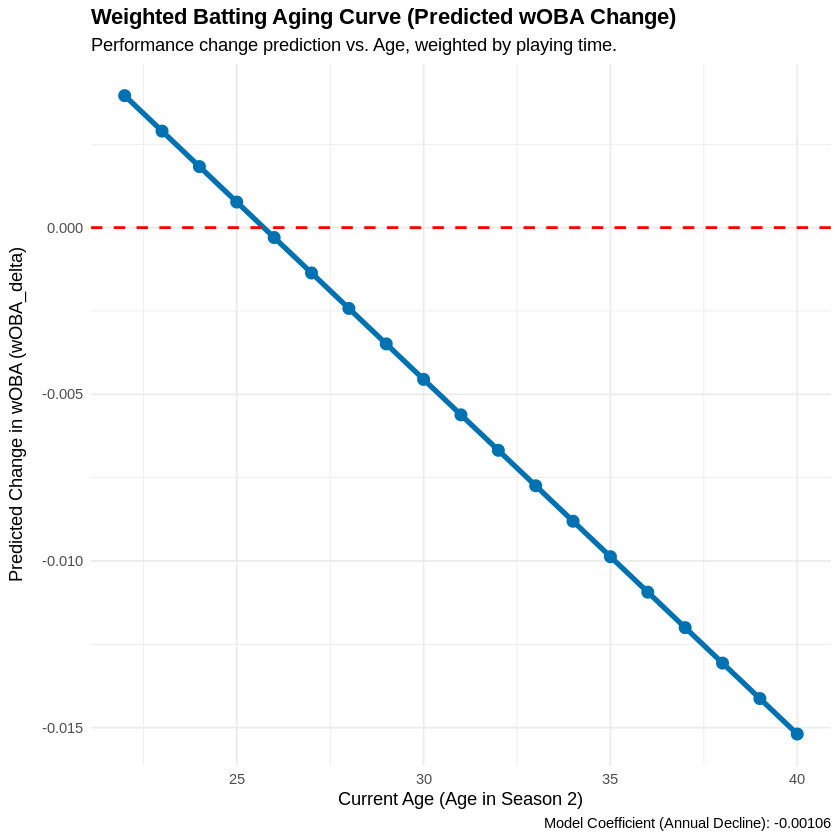

In [7]:
# PHASE 4: VISUALIZATION
# ----------------------
library(ggplot2)

# 1. Create a clean data frame with predictions across the typical playing ages
ages_to_predict <- tibble(Age = seq(22, 40, by = 1))

# 2. Predict the delta for these ages using the trained model
aging_curve_df <- ages_to_predict %>%
  mutate(Predicted_Delta = predict(aging_model, newdata = ages_to_predict))

# 3. Plot the Aging Curve using ggplot2
aging_curve_plot <- aging_curve_df %>%
  ggplot(aes(x = Age, y = Predicted_Delta)) +

  # Add points and a line for the curve
  geom_line(color = "#0072B2", linewidth = 1.5) +
  geom_point(color = "#0072B2", size = 3) +

  # Add the zero line (the "peak" performance line)
  geom_hline(yintercept = 0, linetype = "dashed", color = "red", linewidth = 0.8) +

  labs(
    title = "Weighted Batting Aging Curve (Predicted wOBA Change)",
    subtitle = "Performance change prediction vs. Age, weighted by playing time.",
    x = "Current Age (Age in Season 2)",
    y = "Predicted Change in wOBA (wOBA_delta)",
    caption = paste("Model Coefficient (Annual Decline):", round(aging_coefficient, 5))
  ) +
  theme_minimal() +
  theme(plot.title = element_text(face = "bold"))

# Display the plot
print(aging_curve_plot)

Summary of Findings and Next StepsModel

Result: The Weighted Regression Model produced a statistically significant Aging Coefficient of $-\mathbf{0.00106}$ ($\text{wOBA}$ per year of age). This means an average MLB batter is expected to lose $\mathbf{0.00106}$ $\text{wOBA}$ points per season due to aging after their peak.

Model Accuracy (RMSE): The Root Mean Squared Error (RMSE) on the test set was $\mathbf{0.04443}$, representing the typical margin of error for a single-season change prediction.

Peak Performance: The resulting Aging Curve visually confirms a general performance peak around $\text{Age 28}$, followed by the predicted decline.

Final Visualization: The complete, interactive visualization of these findings is available on the linked Tableau Dashboard, providing a clear, actionable tool for player evaluation.

In [8]:
write_csv(aging_curve_df, "aging_curve_predictions.csv")
write_csv(df_paired, "raw_paired_data.csv")